In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, cwt
from scipy.fft import fft, ifft, fftfreq

%matplotlib inline

In [2]:
# Load and prepare data
data = pd.read_csv("../../data/cyclohexane.csv", header=0)

X = data.drop("solvent", axis=1)
best_sample = X.iloc[0].to_numpy().reshape(-1, 1)

In [3]:
plt.rcParams['font.size'] = 12
xticks = np.linspace(0, X.shape[1]-1, 6, dtype=int)
xlabels = X.columns[xticks].astype(float).astype(int).values

def build_plot():
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')
    plt.ylabel("Intensity (a.u)")
    plt.xlabel("Raman Shift (cm$^{-1}$)")
    plt.xlim([-20, 3296])
    plt.xticks(xticks, labels=xlabels)
    plt.grid(False)
    return fig

## Example Raw Spectra

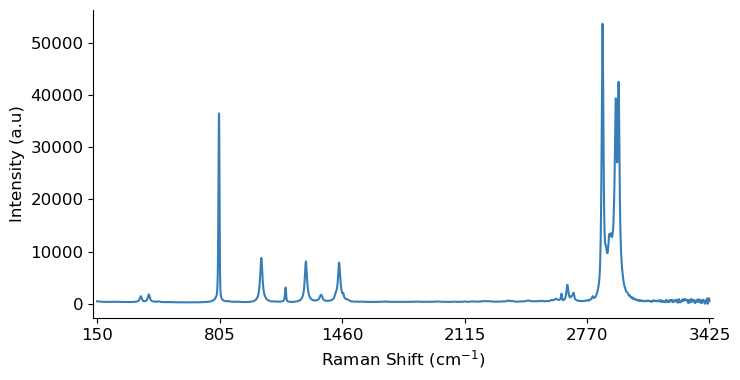

In [4]:
_ = build_plot()
plt.plot(best_sample, "#377eb8");

## Example Batch of Raw Spectra

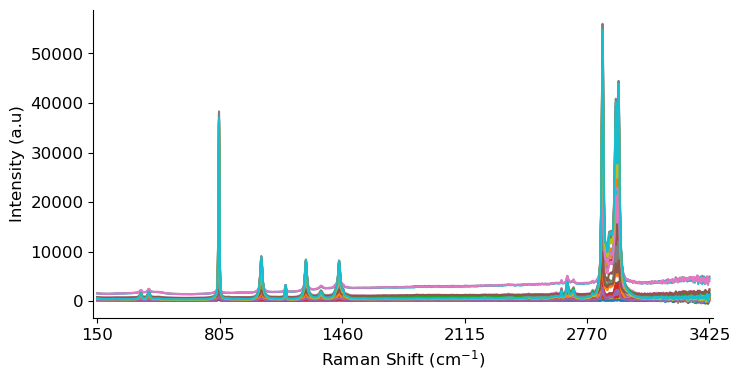

In [5]:
_ = build_plot()
plt.plot(X.iloc[:50, :].T); # semicolon to suppress matplotlib output, can also assign it as _ = plot(.)

## Moving Average Smoothing

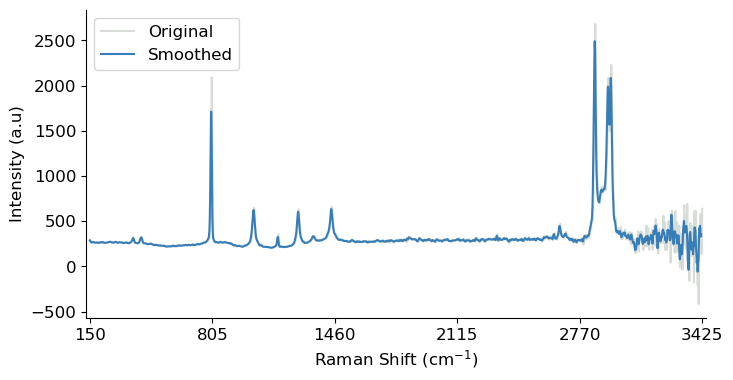

In [6]:
def moving_average(x, w):
    """
    Computes the moving average of a 1D array using a specified window size.

    Parameters:
    x (array-like): 
        The input sequence (list or NumPy array).
    w (int): 
        The window size for computing the moving average.

    Returns:
        np.ndarray: A 1D array of the moving averages.

    Notes:
    np.ones(w): Creates an array of ones of size w (e.g., [1, 1, 1, ..., 1]).
    
    np.convolve(x, np.ones(w), 'valid'): 
        Computes the convolution of x with this window. This effectively sums w consecutive elements of x as the window slides over it.

    'valid': Ensures that only positions where the entire window fits in x are considered, reducing the output size to len(x) - w + 1.
    """
    return np.convolve(x, np.ones(w), 'valid') / w

sample = X.iloc[57]
smoothed_sample = moving_average(sample, 7)

_ = build_plot()
plt.plot(sample, "#d8dcd6", label="Original");
plt.plot(smoothed_sample, "#377eb8",  label="Smoothed");
plt.legend();

## Savitzky–Golay filter

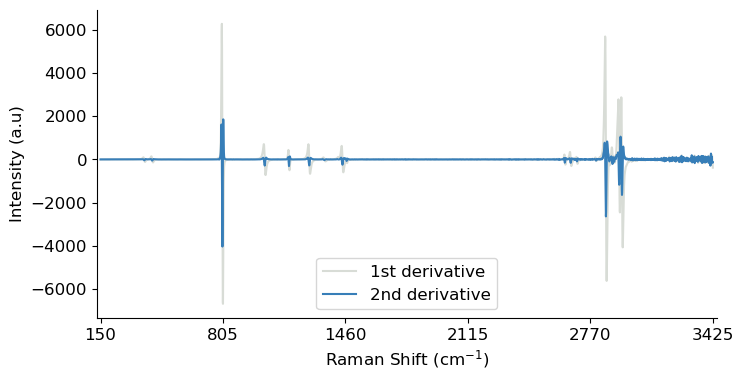

In [7]:
first_deriv_sample = savgol_filter(best_sample.reshape(-1), window_length=5, polyorder=2, deriv=1)
second_deriv_sample = savgol_filter(best_sample.reshape(-1), window_length=5, polyorder=2, deriv=2)

_ = build_plot()
plt.plot(first_deriv_sample, "#d8dcd6", label="1st derivative");
plt.plot(second_deriv_sample, "#377eb8",  label="2nd derivative");
plt.legend();

## Fourier transform

In [8]:
def fourier_smoothing(raman_spectrum, cutoff_frequency):
    
    # Apply FFT to the spectrum
    spectrum_fft = fft(raman_spectrum, n = len(raman_spectrum))
    
    # Get the frequencies corresponding to the FFT components
    frequencies = fftfreq(len(raman_spectrum), d=1) # 1nm resolution
    
    # apply a filter
    filter_mask = np.abs(frequencies) < cutoff_frequency
    print("Number of components remaining", sum(filter_mask))
    
    # Apply the filter to the FFT components
    filtered_spectrum_fft = spectrum_fft * filter_mask
    
    # Apply inverse FFT to get the smoothed spectrum
    smoothed_spectrum = ifft(filtered_spectrum_fft)
    
    # Return the real part of the smoothed spectrum
    return np.abs(frequencies), filter_mask, np.real(spectrum_fft), np.real(smoothed_spectrum)

Number of components remaining 655


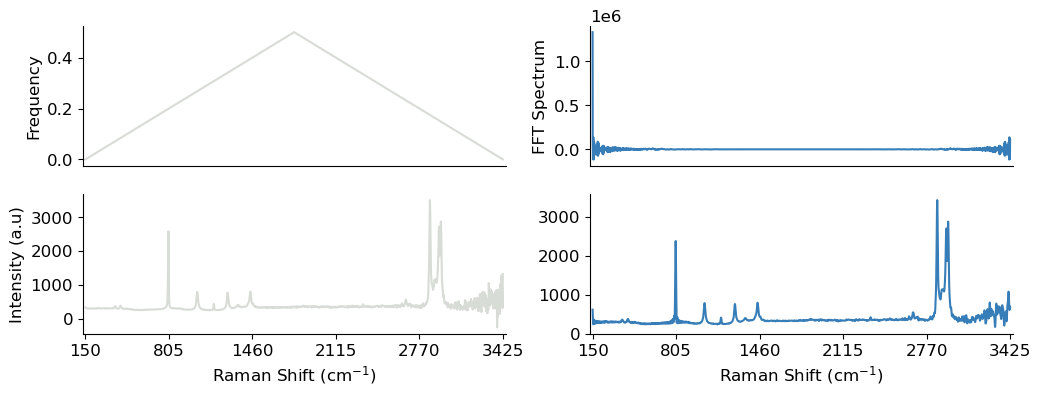

In [9]:
idx = 4
sample = X.iloc[idx].to_numpy().reshape(-1)

frequencies, filter_mask, spectrum_fft, smoothed_spectrum = fourier_smoothing(sample, 0.1)

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(12, 4))
for i in range(2):
    for j in range(2):
        ax[i, j].spines['right'].set_color('none')
        ax[i, j].spines['top'].set_color('none')
        ax[i, j].spines['right'].set_color('none')
        ax[i, j].spines['top'].set_color('none')

ax[0, 0].set_ylabel("Frequency")
ax[0, 0].xaxis.set_ticks_position('none') 
ax[0, 0].plot(frequencies, "#d8dcd6");

ax[0, 1].set_ylabel("FFT Spectrum")
ax[0, 1].xaxis.set_ticks_position('none') 
ax[0, 1].plot(spectrum_fft, "#377eb8");

ax[1, 0].set_ylabel("Intensity (a.u)")
ax[1, 0].set_xlabel("Raman Shift (cm$^{-1}$)")
ax[1, 0].set_xlim([-20, 3296])
ax[1, 0].set_yticks([0, 1000, 2000, 3000], labels=[0, 1000, 2000, 3000]);
ax[1, 0].set_xticks(xticks, labels=xlabels)
ax[1, 0].plot(sample, "#d8dcd6");

ax[1, 1].set_xlabel("Raman Shift (cm$^{-1}$)")
ax[1, 1].set_xlim([-20, 3296])
ax[1, 1].set_xticks(xticks, labels=xlabels)
ax[1, 1].plot(smoothed_spectrum, "#377eb8")
ax[1, 1].set_yticks([0, 1000, 2000, 3000], labels=[0, 1000, 2000, 3000]);